Matthew Virgin <br>
ECE 491 <br>
Final Project <br>
15 December 2023 <br>

Assuming you have already extracted the archive into the same folder as this 
notebook, let's explore the training and testing sets. Note that I also renamed
the "normal" folder in the "Data" folder to "no_tumor"

In [1]:
import os

# Base directories
curr_dir = os.getcwd()
train_folder = os.path.join(curr_dir, "Training")
test_folder = os.path.join(curr_dir, "Testing")

tumor_names = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]
train_dirs = []

# function that takes a parent folder name and a list of its child folder names and
# returns a list containing the proper directory names
def nameFolders(parent_name, child_name_list):
    dirs = []
    for name in child_name_list:
        full_path = os.path.join(parent_name, name)
        dirs.append(full_path)
    return dirs

# list of each train directory
train_dirs = nameFolders(train_folder, tumor_names)

# list of each test directory
test_dirs = nameFolders(test_folder, tumor_names)

#TODO have the program create the training and testing folders if they dont exist, that way I can just tell him to extract archive and run the program. Maybe also have this program rename normal to no_tumor

In [2]:
# Put the images from the "Data" folder into the correct places in the 
# "Training" and "Testing" folders

from sklearn.model_selection import train_test_split
import shutil

data_folder = os.path.join(curr_dir, "Data")
# Note: I renamed the "normal" folder in "Data" to "no_tumor" for consistency
data_dirs = nameFolders(data_folder, tumor_names)

# splits subchildren into train and test sets,
# moving their contents to the provided locations
def split_and_move(children):
    train_ratio = 0.6
    for i in range(len(children)):
        
        # list images in folder
        all_images = [f for f in os.listdir(children[i]) if f.endswith('.jpg')]

        train_images, test_images = train_test_split(all_images, train_size=train_ratio, random_state=42)

        for image in train_images:
            shutil.move(os.path.join(children[i], image), os.path.join(train_dirs[i], image))

        for image in test_images:
            shutil.move(os.path.join(children[i], image), os.path.join(test_dirs[i], image))


split_and_move(data_dirs)
#TODO see the difference between original dataset and cleaned one since I can just resize in the generator

ValueError: With n_samples=0, test_size=None and train_size=0.6, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [3]:
# function to print the length of each directory
def print_directory_lengths(directory, name):
    files = os.listdir(directory)
    print(f"{name} directory ({directory}): {len(files)} files")
    return len(files)

train_samples = 0
test_samples = 0

# print the length of each training directory
for i in range(len(train_dirs)):
    train_samples = train_samples + print_directory_lengths(train_dirs[i], "train " + tumor_names[i])
    
# print the length of each test directory
for i in range(len(test_dirs)):
    test_samples = test_samples + print_directory_lengths(test_dirs[i], "test " + tumor_names[i])
    

train glioma_tumor directory (c:\Users\Matt\Desktop\School\ECE-491\Training\glioma_tumor): 540 files
train meningioma_tumor directory (c:\Users\Matt\Desktop\School\ECE-491\Training\meningioma_tumor): 547 files
train no_tumor directory (c:\Users\Matt\Desktop\School\ECE-491\Training\no_tumor): 262 files
train pituitary_tumor directory (c:\Users\Matt\Desktop\School\ECE-491\Training\pituitary_tumor): 506 files
test glioma_tumor directory (c:\Users\Matt\Desktop\School\ECE-491\Testing\glioma_tumor): 361 files
test meningioma_tumor directory (c:\Users\Matt\Desktop\School\ECE-491\Testing\meningioma_tumor): 366 files
test no_tumor directory (c:\Users\Matt\Desktop\School\ECE-491\Testing\no_tumor): 176 files
test pituitary_tumor directory (c:\Users\Matt\Desktop\School\ECE-491\Testing\pituitary_tumor): 338 files


train samples


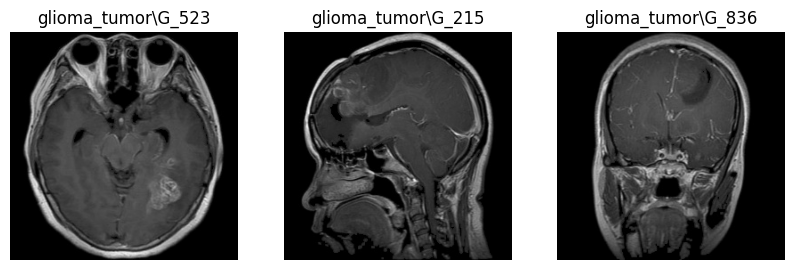

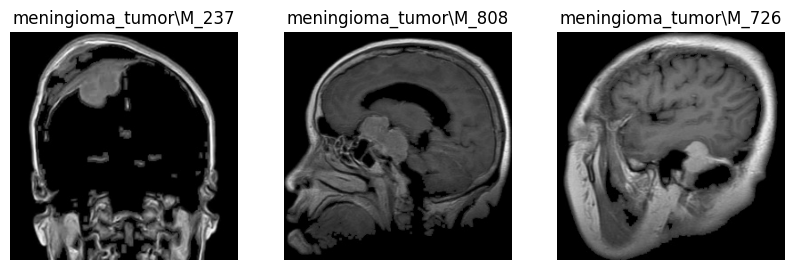

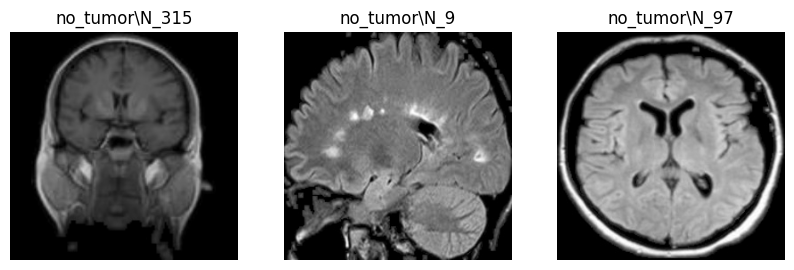

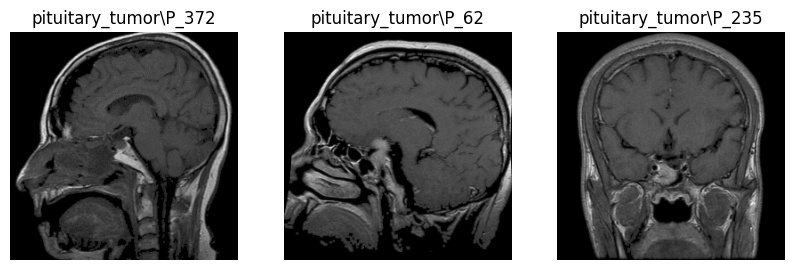

test samples


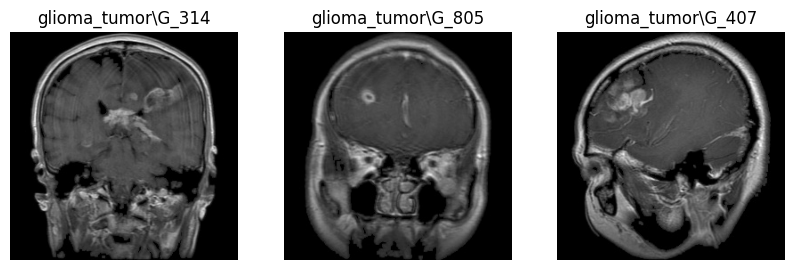

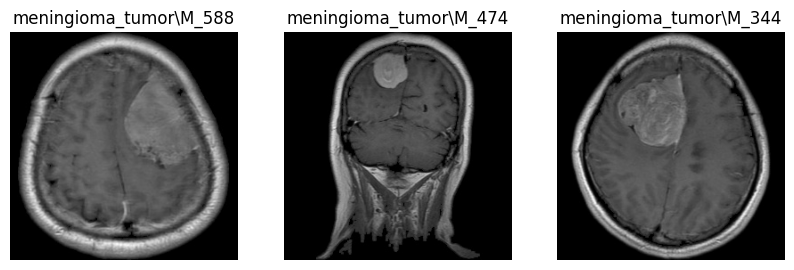

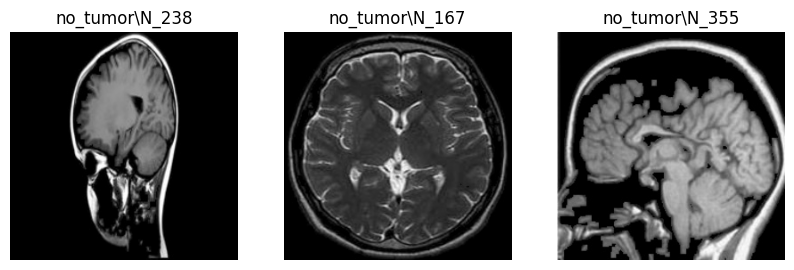

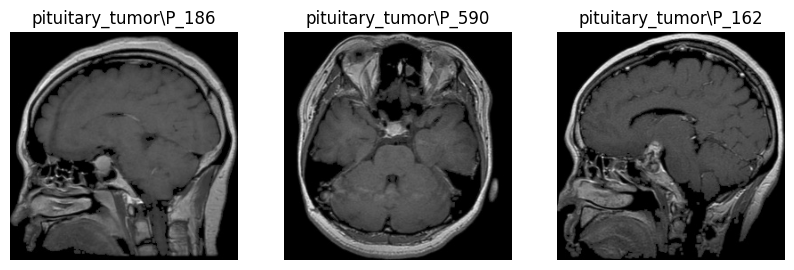

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# TODO rename images so I know which tumor, particularly test set?
# TODO am I sure my tumors and images match? - it appears so

# Function to display three random images from a directory
def display_random_images(directory):
    files = os.listdir(directory)
    random_images = random.sample(files, 3)

    # Plot the random images
    plt.figure(figsize=(10, 5))
    for i, image_file in enumerate(random_images, 1):
        image_path = os.path.join(directory, image_file)

        # get the directory index for clearer labels
        second_to_last_backslash_index = image_path.rfind('\\', 0, image_path.rfind('\\'))

        plt.subplot(1, 3, i)
        img = mpimg.imread(image_path)
        plt.imshow(img)

        # title of each image includes tumor type and image name, cut off .jpg
        plt.title(f"{image_path[second_to_last_backslash_index+1:-4]}")

        plt.axis("off")

    plt.show()

# Display train samples
print("train samples")
for i in range(len(train_dirs)):
    display_random_images(train_dirs[i])

# Display test samples
print("test samples")
for i in range(len(test_dirs)):
    display_random_images(test_dirs[i])

Building the model:

In [5]:
import numpy as np
import tensorflow as tf
import math
from tensorflow import keras
from keras import layers
from keras import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.applications.efficientnet import preprocess_input
from keras.callbacks import LearningRateScheduler

# TODO me calling tf or keras or tf.keras.blah is really inconsistent
# DONE TODO: DONE add stuff from other homeworks than 4, best model saving, lr scheduler, etc - see hw6 for callbacks(best model saving) and lr scheduler
# DONE TODO: check if my images are really greyscale or rgb
# DONE TODO: if greyscale, change them to be fake RGB / have 3 channels and see how perf changes - can be done with numpy or with keras (https://keras.io/api/data_loading/image/)
# TODO: check original dataset
# TODO: use professor solution from email - ie NEED MORE VALIDATION DATA
# TODO: add view of classifcation like hw4
# see notes for more
# DONE TODO: actually perform fine tuning
# TODO: regularization like flipping/rotating
# TODO: inconsistent tabs

img_size = 256 
num_classes = 4
BATCH_SIZE = 20

pre_model = tf.keras.applications.EfficientNetV2S(
    include_top=False,
    weights="imagenet",
    input_shape = (img_size, img_size, 3)   # we fabricate the two extra channels
)

# freeze model
pre_model.trainable = False

# build top layers but not the rest (point of using pre-trained)
x = pre_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)

top_dropout_rate = 0.5
x = layers.Dropout(top_dropout_rate)(x)
outputs = layers.Dense(num_classes, activation = "softmax")(x)

# Configure and compile the model
model = Model(inputs = pre_model.input, outputs = outputs)

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['acc'])

## prepare train and test generators
# train gen has augmentations like rotations and flips
train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
        train_folder, # This is the source directory for training images
      #  target_size=(150, 150),  # All images will be resized to 150x150 TODO everything should already be resized but good to check the difference between datasets sometime
        batch_size= BATCH_SIZE,
        shuffle = True,
        color_mode="rgb",       # force 3 channels for use w efficientnet
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='categorical')

# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        test_folder,
       # target_size=(150, 150),
        batch_size= BATCH_SIZE,
        shuffle = True,
	color_mode="rgb",
        class_mode='categorical')

## callbacks
# model checkpoint
save_model_path = '/tmp/weights.hdf5'
cp = tf.keras.callbacks.ModelCheckpoint(filepath=save_model_path, monitor='val_loss', mode='min', save_best_only=True)

# early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',  # Monitor the validation loss
                                        patience=10,          # Number of epochs with no improvement after which training will be stopped
				        restore_best_weights=True)      # Restore best weights from that period

# learning rate scheduler
def scheduler(epoch, lr):
	initial_lrate = 0.001
	drop = 0.1
	epochs_drop = 10
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate

lr_schedule = LearningRateScheduler(scheduler)

history = model.fit(
      train_generator,
      steps_per_epoch=int(np.ceil(train_samples / float(BATCH_SIZE))),
      epochs=50,
      validation_data=validation_generator,
      validation_steps=int(np.ceil(test_samples / float(BATCH_SIZE))),
      callbacks = [cp, es, lr_schedule],
      verbose=1)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 128, 128, 24  648         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

Analysis

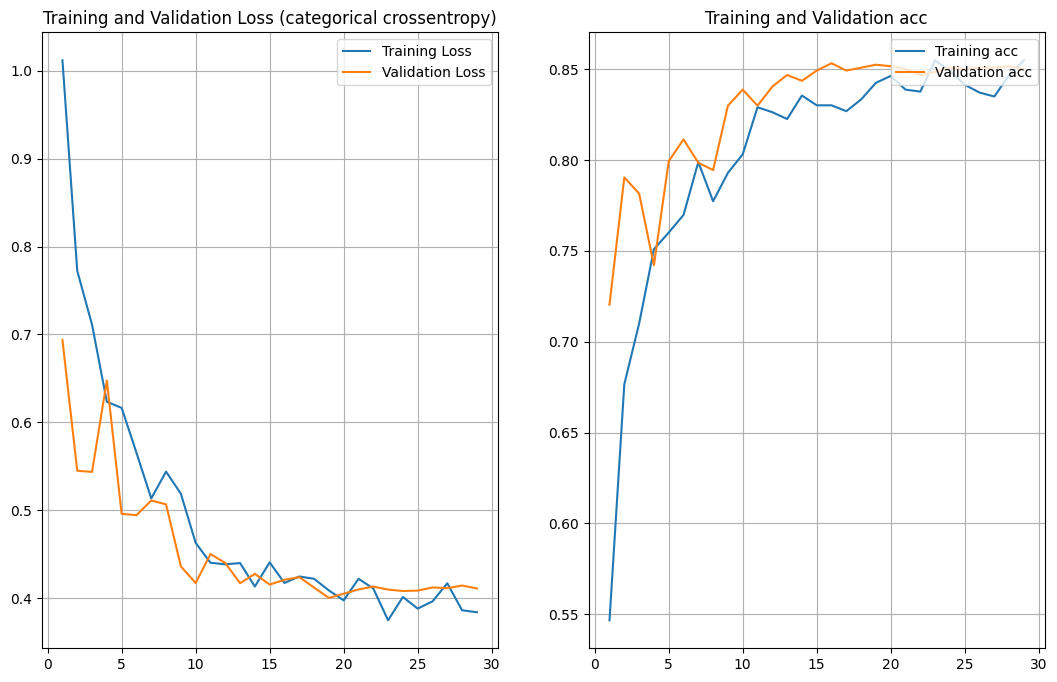

In [6]:
def plot_history(history, SKIP):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    acc = history.history['acc']
    val_acc = history.history['val_acc']

    epochs_range = range(1, len(loss) + 1)

    plt.figure(figsize=(20, 8))
    plt.subplot(1, 3, 2)
    plt.plot(epochs_range[SKIP:], loss[SKIP:], label='Training Loss')
    plt.plot(epochs_range[SKIP:], val_loss[SKIP:], label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss (categorical crossentropy)')
    plt.grid()

    plt.subplot(1, 3, 3)
    plt.plot(epochs_range[SKIP:], acc[SKIP:], label='Training acc')
    plt.plot(epochs_range[SKIP:], val_acc[SKIP:], label='Validation acc')
    plt.legend(loc='upper right')
    plt.title('Training and Validation acc')

    plt.grid()
    plt.show()

plot_history(history, 0)

Fine-tuning

In [7]:
# Unfreeze the base model and train end to end
pre_model.trainable = True
# for layer in model.layers[-20:]:
#         if not isinstance(layer, layers.BatchNormalization):
#             layer.trainable = True
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['acc'])

history = model.fit(
      train_generator,
      steps_per_epoch=int(np.ceil(train_samples / float(BATCH_SIZE))),
      epochs=35,
      validation_data=validation_generator,
      validation_steps=int(np.ceil(test_samples / float(BATCH_SIZE))),
      callbacks = [cp, es, lr_schedule],
      verbose=1)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 128, 128, 24  648         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

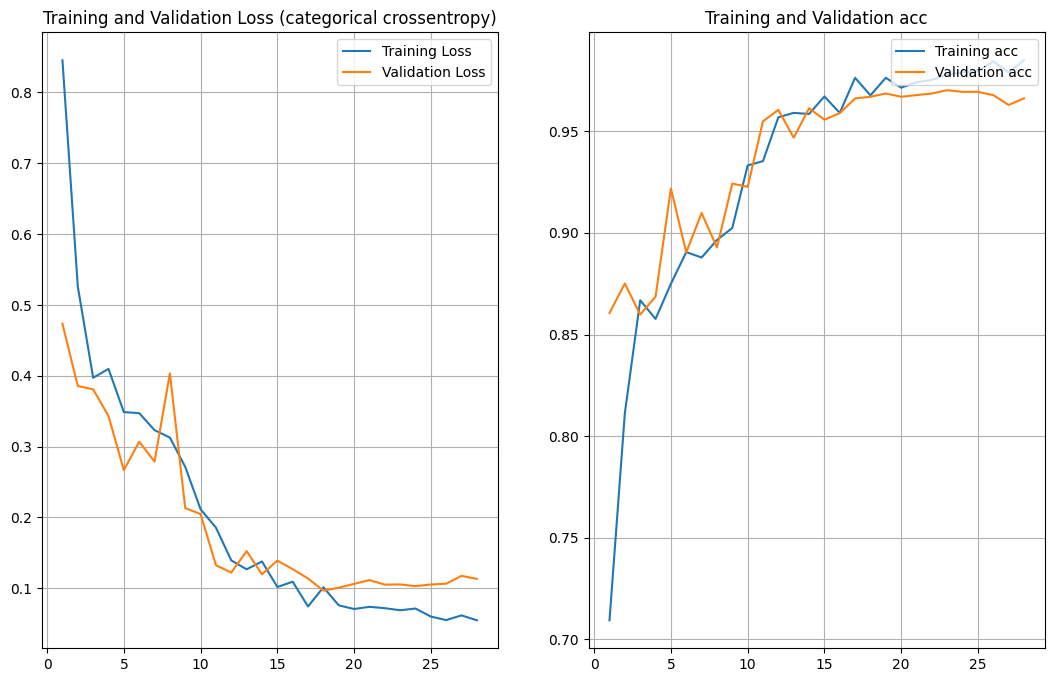

In [8]:
plot_history(history, 0)